**This script takes the best models and features from Phase 1 of the model selection process and undertakes a deeper dive in reviewing/selecting the optimal models.  It also adapts wrangling steps to a Pipeline.**

To-Do:
- Use balanced sample of 50K observations DONE
- Align features across scripts DONE for outcome variable - PENDING for features (scale, reformat, normalize)
- Substitute dummies for label encoding, create a pipeline - PENDING
- Add CV; randomize splits - PENDING
- Review validation curve, precision versus recall
- Robustness checks for county_type versus MSA binary
- Holdout sets
- Review learning curve
- Grid search
- Analyses on all years

In [1]:
%matplotlib inline

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

**Import 2017 sample of 50,000 observations balanced for 1/0 Action Taken, removing two action_taken_name values.**  Note import warning:"Columns (29,30,39,40) have mixed types. Specify dtype option on import or set low_memory=False."

In [2]:
filepath = os.path.abspath(os.path.join( "..", "fixtures", "hmda2017sample_balanced.csv"))
DATA = pd.read_csv(filepath, low_memory=False)

**Drop features with missing data, locality information, and features resulting in model leakage**

In [3]:
DATA = DATA.drop(DATA.columns[0], axis=1)

DATA = DATA.drop(['purchaser_type_name',
        'preapproval_name',
        'rate_spread', 
        'sequence_number', 
        'respondent_id',
        'state_name',
        'state_abbr',
        'county_name',
        'edit_status_name', 
        'denial_reason_name_3', 
        'denial_reason_name_2', 
        'denial_reason_name_1', 
        'co_applicant_race_name_5', 
        'co_applicant_race_name_4', 
        'co_applicant_race_name_3', 
        'co_applicant_race_name_2',
        'census_tract_number',
        'application_date_indicator', 
        'applicant_race_name_5', 
        'applicant_race_name_4', 
        'applicant_race_name_3', 
        'applicant_race_name_2', 
        'agency_name'], 
        axis=1)


In [4]:
DATA['locality_type'] = None

In [5]:
DATA['locality_type'] = None
cloc = DATA.columns.get_loc('locality_type')

i = 0
for x in DATA['msamd_name'].isna():
    if x == True:
        DATA.iat[i, cloc]= 0
        
    else: 
        DATA.iat[i, cloc]= 1
        
    i+=1
        
pd.crosstab(DATA['msamd_name'],DATA['locality_type'], margins=True, dropna=False) #dropna=False

locality_type,0,1,All
msamd_name,,,
Abilene - TX,0,35,35
"Aguadilla, Isabela - PR",0,6,6
Akron - OH,0,45,45
Albany - GA,0,35,35
Albany - OR,0,29,29
"Albany, Schenectady, Troy - NY",0,73,73
Albuquerque - NM,0,163,163
Alexandria - LA,0,16,16
"Allentown, Bethlehem, Easton - PA, NJ",0,134,134


In [6]:
DATA.describe(include='all')

,tract_to_msamd_income,population,minority_population,number_of_owner_occupied_units,number_of_1_to_4_family_units,loan_amount_000s,hud_median_family_income,applicant_income_000s,property_type_name,owner_occupancy_name,...,co_applicant_sex_name,co_applicant_race_name_1,co_applicant_ethnicity_name,as_of_year,applicant_sex_name,applicant_race_name_1,applicant_ethnicity_name,agency_abbr,action_taken_name,locality_type
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,44246.000000,50000,50000,...,50000,50000,50000,50000.0,50000,50000,50000,50000,50000,50000.0
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,3,...,5,8,5,NaN,4,7,4,6,5,2.0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,One-to-four family dwelling (other than manufa...,Owner-occupied as a principal dwelling,...,No co-applicant,No co-applicant,No co-applicant,NaN,Male,White,Not Hispanic or Latino,HUD,Loan originated,1.0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47112,45053,...,27495,27495,27495,NaN,28255,32128,34673,24817,19417,44152.0
mean,110.760058,5633.718300,33.533193,1434.35328,1977.296320,228.458040,70502.446000,104.416580,NaN,NaN,...,NaN,NaN,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
std,40.470068,3012.190961,27.023663,833.92800,1033.910772,591.345455,15045.781898,641.071633,NaN,NaN,...,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
min,0.000000,87.000000,0.000000,0.00000,0.000000,1.000000,15800.000000,1.000000,NaN,NaN,...,NaN,NaN,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
25%,84.839996,3826.000000,11.530000,909.00000,1332.000000,97.000000,61100.000000,47.000000,NaN,NaN,...,NaN,NaN,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
50%,105.470001,5120.000000,25.160000,1301.00000,1808.000000,172.000000,67900.000000,74.000000,NaN,NaN,...,NaN,NaN,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN
75%,130.552502,6726.000000,50.049999,1782.00000,2397.000000,279.000000,76300.000000,117.000000,NaN,NaN,...,NaN,NaN,NaN,2017.0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print("DATA dimensions: {}".format(DATA.shape))

DATA dimensions: (50000, 25)


**Write the initial script using subset of features which are already int or float, plus the target** 

**NOTE: discard file closed, call 'application approved but not accepted" a 1 or discard, discard 'application withdrawn by applicant'.  Concern about overfitting if we leave too much stuff in.**

In [8]:
DATA['action_taken'] = DATA.action_taken_name.apply(lambda x: 1 if x in ['Loan purchased by the institution', 'Loan originated'] else 0)
pd.crosstab(DATA['action_taken_name'],DATA['action_taken'], margins=True)

action_taken,0,1,All
action_taken_name,,,
Application denied by financial institution,19414,0,19414
File closed for incompleteness,5578,0,5578
Loan originated,0,19417,19417
Loan purchased by the institution,0,5583,5583
Preapproval request denied by financial institution,8,0,8
All,25000,25000,50000


**ACTION: look at imputing income using hud household median income rather than mean**

In [9]:
DATA_targ_numeric = DATA[['action_taken',
            'tract_to_msamd_income', 
            'population', 
            'minority_population', 
            'number_of_owner_occupied_units', 
            'number_of_1_to_4_family_units', 
            'loan_amount_000s', 
            'hud_median_family_income', 
            'applicant_income_000s', 'locality_type'
            ]]
#resolve missing values in applicant_income_000s
DATA_targ_numeric.fillna(DATA_targ_numeric.mean(), inplace=True)
DATA_targ_numeric.info()
DATA_basefile = DATA_targ_numeric

C:\Users\akx00\Anaconda3\lib\site-packages\pandas\core\generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 10 columns):
action_taken                      50000 non-null int64
tract_to_msamd_income             50000 non-null float64
population                        50000 non-null int64
minority_population               50000 non-null float64
number_of_owner_occupied_units    50000 non-null int64
number_of_1_to_4_family_units     50000 non-null int64
loan_amount_000s                  50000 non-null int64
hud_median_family_income          50000 non-null int64
applicant_income_000s             50000 non-null float64
locality_type                     50000 non-null int64
dtypes: float64(3), int64(7)
memory usage: 3.8 MB


**Use one-hot encoding via Pandas, concatenate to the rest of the data frame.**

Reference link:
https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python

In [10]:
DATA = DATA.drop(['action_taken_name', 'msamd_name'], axis=1)
DATA.columns

Index(['tract_to_msamd_income', 'population', 'minority_population',
       'number_of_owner_occupied_units', 'number_of_1_to_4_family_units',
       'loan_amount_000s', 'hud_median_family_income', 'applicant_income_000s',
       'property_type_name', 'owner_occupancy_name', 'loan_type_name',
       'loan_purpose_name', 'lien_status_name', 'hoepa_status_name',
       'co_applicant_sex_name', 'co_applicant_race_name_1',
       'co_applicant_ethnicity_name', 'as_of_year', 'applicant_sex_name',
       'applicant_race_name_1', 'applicant_ethnicity_name', 'agency_abbr',
       'locality_type', 'action_taken'],
      dtype='object')

In [11]:
non_categorical_features = ['action_taken',
                        'tract_to_msamd_income', 
                        'population', 
                        'minority_population', 
                        'number_of_owner_occupied_units', 
                        'number_of_1_to_4_family_units', 
                        'loan_amount_000s', 
                        'hud_median_family_income', 
                        'applicant_income_000s',
                        'locality_type'
                       ]

In [12]:
for categorical_feature in list(DATA.columns):
    if categorical_feature not in non_categorical_features:
        DATA[categorical_feature] = DATA[categorical_feature].astype('category')
        dummies = pd.get_dummies(DATA[categorical_feature], prefix=categorical_feature)
        DATA_basefile = pd.concat([DATA_basefile, dummies], axis=1)
        
DATA_basefile.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 69 columns):
action_taken                                                                                                     50000 non-null int64
tract_to_msamd_income                                                                                            50000 non-null float64
population                                                                                                       50000 non-null int64
minority_population                                                                                              50000 non-null float64
number_of_owner_occupied_units                                                                                   50000 non-null int64
number_of_1_to_4_family_units                                                                                    50000 non-null int64
loan_amount_000s                                                                   

In [13]:
tofilepath = os.path.abspath(os.path.join( "..", "fixtures", "hmda2017sample_alltest_state_localitytest.csv"))
DATA_basefile.to_csv(tofilepath, index=False)

In [14]:
# Determine the shape of the data
print("{} instances with {} features\n".format(*DATA_basefile.shape))

# Determine the frequency of each class
print(pd.crosstab(index=DATA['action_taken'], columns="count"))

50000 instances with 69 features

col_0         count
action_taken       
0             25000
1             25000


## Classification 


In [15]:
from sklearn import metrics

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn import tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from yellowbrick.classifier import ClassificationReport

In [16]:
X = DATA_basefile[DATA_basefile.columns[1:]]
y = DATA_basefile['action_taken']

In [17]:
def score_model(X, y, model, **kwargs):
    """
    Test various estimators.
    """ 
    #NOTE: for capstone add X_test, X_train, Y_test, Y_train for capstone code.  
    #Bake into model to see if it does cross validation, if not there do CV.
   
    scores = {'precision':[], 'recall':[], 'accuracy':[], 'f1':[]}
    
    # Instantiate the classification model and visualizer
    model.fit(X, y, **kwargs)  
    
    expected  = y
    predicted = model.predict(X)
        
    # Append our scores to the tracker
    scores['precision'].append(metrics.precision_score(expected, predicted, average="binary"))
    scores['recall'].append(metrics.recall_score(expected, predicted, average="binary"))
    scores['accuracy'].append(metrics.accuracy_score(expected, predicted))
    scores['f1'].append(metrics.f1_score(expected, predicted, average="binary"))
        
    # Compute and return F1 (harmonic mean of precision and recall), Precision, Recall, Accuracy   
    print("{}".format(model.__class__.__name__))    
    print("Validation scores are as follows:\n")
    print(pd.DataFrame(scores).mean())

In [18]:
# Try them all!
models = [
    GaussianNB(), 
    MultinomialNB(),
    BernoulliNB(),
    tree.DecisionTreeClassifier(),
    LinearDiscriminantAnalysis(),
    LogisticRegression(solver='lbfgs', max_iter=6000), 
    LogisticRegressionCV(cv=3, max_iter=6000), 
    BaggingClassifier(), 
    ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100),
    LinearSVC(max_iter=6000)
]
for model in models:
    score_model(X, y, model)

GaussianNB
Validation scores are as follows:

precision    0.609616
recall       0.813520
accuracy     0.646280
f1           0.696960
dtype: float64
MultinomialNB
Validation scores are as follows:

precision    0.636350
recall       0.520280
accuracy     0.611480
f1           0.572491
dtype: float64
BernoulliNB
Validation scores are as follows:

precision    0.809500
recall       0.451960
accuracy     0.672800
f1           0.580061
dtype: float64
DecisionTreeClassifier
Validation scores are as follows:

precision    1.00000
recall       0.99996
accuracy     0.99998
f1           0.99998
dtype: float64


C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LinearDiscriminantAnalysis
Validation scores are as follows:

precision    0.745346
recall       0.664640
accuracy     0.718780
f1           0.702683
dtype: float64
LogisticRegression
Validation scores are as follows:

precision    0.545264
recall       0.644000
accuracy     0.553460
f1           0.590533
dtype: float64
LogisticRegressionCV
Validation scores are as follows:

precision    0.546847
recall       0.644120
accuracy     0.555180
f1           0.591511
dtype: float64
BaggingClassifier
Validation scores are as follows:

precision    0.994843
recall       0.972240
accuracy     0.983600
f1           0.983412
dtype: float64
ExtraTreesClassifier
Validation scores are as follows:

precision    1.00000
recall       0.99996
accuracy     0.99998
f1           0.99998
dtype: float64
RandomForestClassifier
Validation scores are as follows:

precision    0.99996
recall       1.00000
accuracy     0.99998
f1           0.99998
dtype: float64
LinearSVC
Validation scores are as follows:

precis

C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


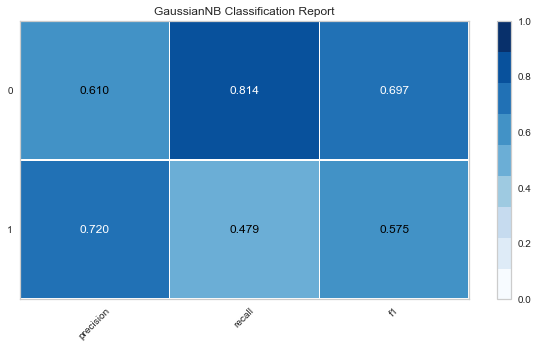

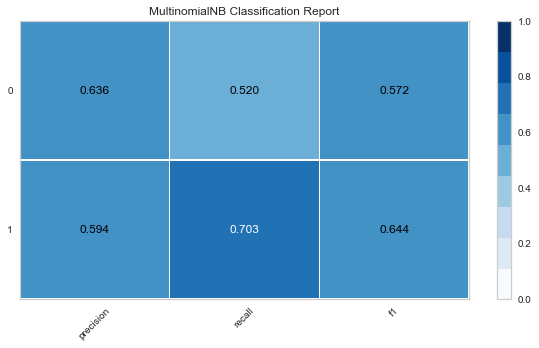

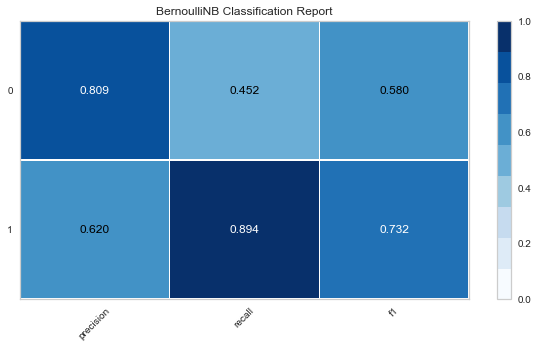

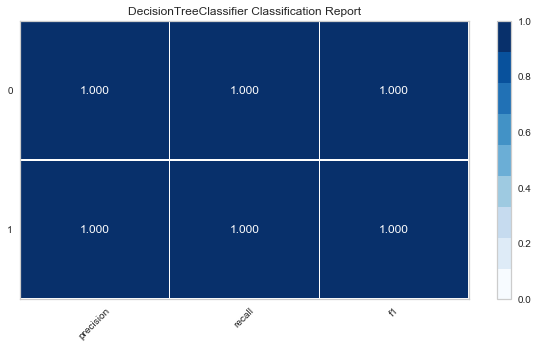

C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


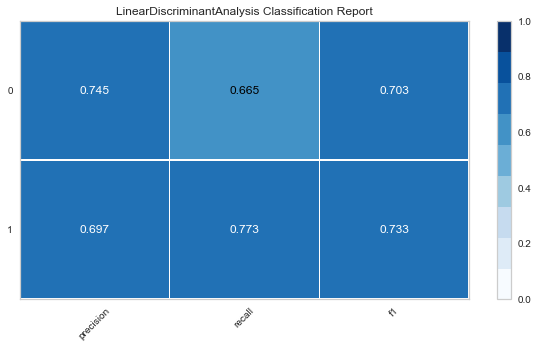

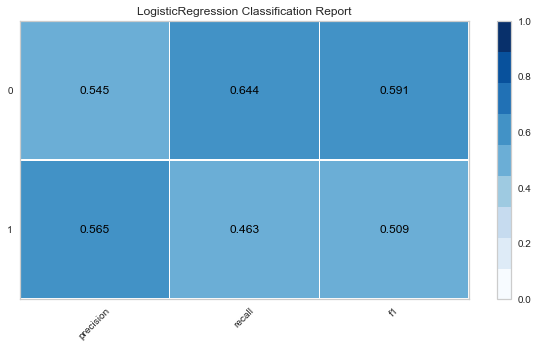

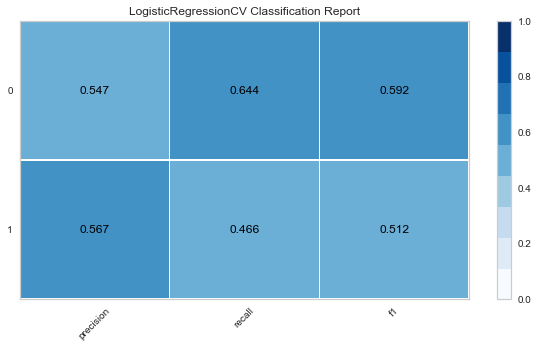

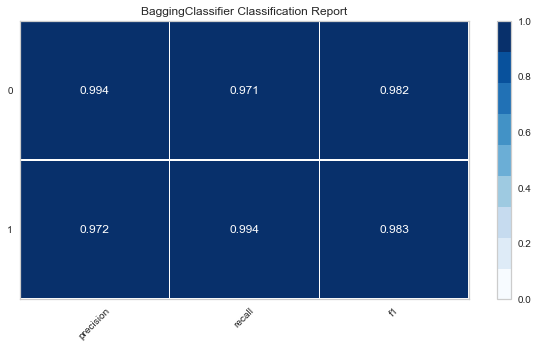

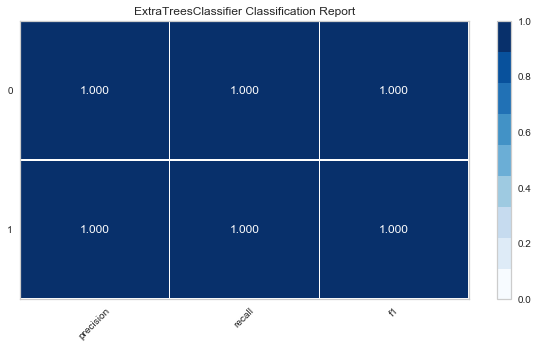

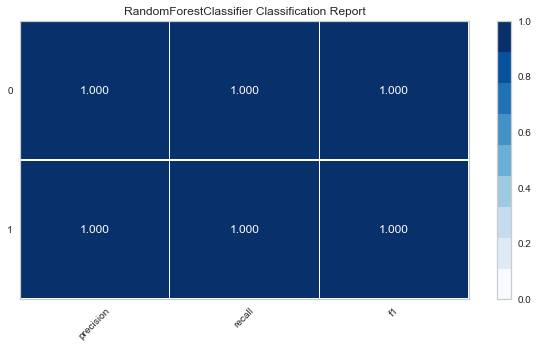

C:\Users\akx00\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
def visualize_model(X, y, estimator):
    """
    Test various estimators.
    """ 
    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=[1,0], 
        cmap="Blues", size=(600, 360)
    )
    visualizer.fit(X, y)  
    visualizer.score(X, y)
    visualizer.poof()  

for model in models:
    visualize_model(X, y, model)

In [ ]:
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model, size=(1080, 720))

viz.fit(X, y)
# Note: the FeatureImportances visualizer is a model visualizer,
# not a feature visualizer, so it doesn't have a transform method!
viz.poof()

In [ ]:
from yellowbrick.features import Rank2D

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson', size=(1080, 720))

visualizer.fit(X, y)
visualizer.transform(X)
visualizer.poof()